<a href="https://colab.research.google.com/github/Ajay-user/ML-DL-RL-repo/blob/master/Image%20Classification/TF_Hub_for_TF2_Retraining_an_image_classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import itertools
import os
import pathlib

import matplotlib.pylab as plt
import numpy as np

import tensorflow as tf
import tensorflow_hub as hub

## Data 📦 

In [ ]:
data_dir = tf.keras.utils.get_file(
    'flower_photos',
    'https://storage.googleapis.com/download.tensorflow.org/example_images/flower_photos.tgz',
    untar=True)

228813984/228813984 [==============================] - 2s 0us/step


In [ ]:
print('Data  : ',data_dir)
flowers = pathlib.Path(data_dir)

Data  :  /root/.keras/datasets/flower_photos


In [ ]:
[i for i in flowers.iterdir()]

[PosixPath('/root/.keras/datasets/flower_photos/sunflowers'),
 PosixPath('/root/.keras/datasets/flower_photos/tulips'),
 PosixPath('/root/.keras/datasets/flower_photos/roses'),
 PosixPath('/root/.keras/datasets/flower_photos/daisy'),
 PosixPath('/root/.keras/datasets/flower_photos/dandelion'),
 PosixPath('/root/.keras/datasets/flower_photos/LICENSE.txt')]

/root/.keras/datasets/flower_photos/daisy/3711723108_65247a3170.jpg
/root/.keras/datasets/flower_photos/daisy/4993492878_11fd4f5d12.jpg
/root/.keras/datasets/flower_photos/daisy/521762040_f26f2e08dd.jpg
/root/.keras/datasets/flower_photos/daisy/835750256_3f91a147ef_n.jpg
/root/.keras/datasets/flower_photos/daisy/20773528301_008fcbc5a1_n.jpg


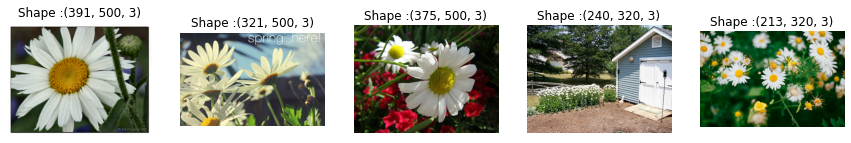

In [ ]:
daisy = pathlib.Path('/root/.keras/datasets/flower_photos/daisy')
pics=[]
for i in list(daisy.iterdir())[:5]:
    print(i)
    pics.append(i)
j=1
plt.figure(figsize=(15,15))
for i in pics:
    raw = tf.io.read_file(r"{0}".format(i))
    img = tf.image.decode_jpeg(raw, channels=3)
    plt.subplot(1,5,j)
    plt.imshow(img);
    plt.title(f"Shape :{img.shape}");
    plt.axis('off')
    j+=1

### Model expect image of size 512 * 512


### `tf.image.resize`

The return value has type float32, unless the method is ResizeMethod.NEAREST_NEIGHBOR, then the return dtype is the dtype of images:

`preserve_aspect_ratio`	Whether to preserve the aspect ratio. If this is set, then images will be resized to a size that fits in size while preserving the aspect ratio of the original image. Scales up the image if size is bigger than the current size of the image. Defaults to False.

In [ ]:
methods = "bilinear, lanczos3, lanczos5, bicubic, gaussian, nearest, area, mitchellcubic"
methods =[m.strip() for m in methods.split(',')]

def tf_img_resize(**kwargs):
    img_r = tf.image.resize(**kwargs)
    img_r = tf.clip_by_value(img_r, 0, 255)   # simply casting the image as uint8 will do, we don't have to clip
    img_r = tf.cast(img_r, dtype=tf.uint8)
    return img_r

def display_image_after_resize(img_r):
    plt.imshow(img_r)
    plt.title(f"Shape : {img_r.shape}")
    plt.axis('off');

def resize_util(**kwargs):
    img_r = tf_img_resize(**kwargs)
    display_image_after_resize(img_r)

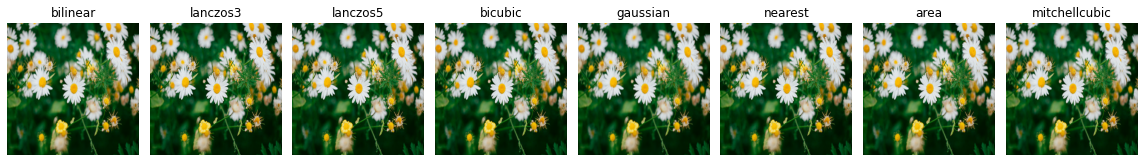

In [ ]:
plt.figure(figsize=(16,16))
for i,m in enumerate(methods):
    plt.subplot(1,8,i+1)
    resize_util(images=img, size=(512,512), method=m)
    plt.title(m)

plt.tight_layout()

## `tf.image.resize_with_pad`

Resizes an image to a target width and height by keeping the aspect ratio the same without distortion. If the target dimensions don't match the image dimensions, the image is resized and then padded with zeroes to match requested dimensions.

In [ ]:
def tf_img_resize_with_padding(**kwargs):
    img_r = tf.image.resize_with_pad(**kwargs )
    img_r = tf.clip_by_value(img_r, 0, 255)
    img_r = tf.cast(img_r, dtype=tf.uint8)
    return img_r

def resize_with_pad_util(**kwargs):
    img_r = tf_img_resize_with_padding(**kwargs)
    display_image_after_resize(img_r)

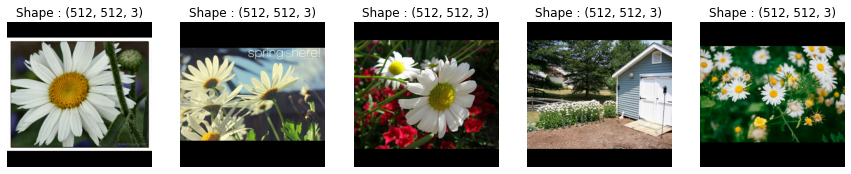

In [ ]:
j=1
plt.figure(figsize=(15,15))
for i in pics:
    raw = tf.io.read_file(r"{0}".format(i))
    img = tf.image.decode_jpeg(raw, channels=3)
    plt.subplot(1,5,j)
    resize_with_pad_util(image=img, target_height=512, target_width=512, method='bilinear')
    j+=1

## DATASET :💿

### `tf.keras.utils.image_dataset_from_directory`

`batch_size` 	Size of the batches of data. Default: 32. If None, the data will not be batched (the dataset will yield individual samples).

`image_size`	Size to resize images to after they are read from disk, specified as (height, width). Defaults to (256, 256). Since the pipeline processes batches of images that must all have the same size, this must be provided.

`interpolation`	String, the interpolation method used when resizing images. Defaults to bilinear. Supports bilinear, nearest, bicubic, area, lanczos3, lanczos5, gaussian, mitchellcubic.

`crop_to_aspect_ratio`	If True, resize the images without aspect ratio distortion. When the original aspect ratio differs from the target aspect ratio, the output image will be cropped so as to return the largest possible window in the image (of size image_size) that matches the target aspect ratio. By default (crop_to_aspect_ratio=False), aspect ratio may not be preserved.

In [ ]:
train = tf.keras.utils.image_dataset_from_directory(flowers,
                                                    batch_size=32,
                                                    validation_split=0.2,
                                                    subset='training', seed=42,
                                                    image_size=(512,512), interpolation='bilinear')

val = tf.keras.utils.image_dataset_from_directory(flowers,
                                                    batch_size=32,
                                                    validation_split=0.2,
                                                    subset='validation', seed=42,
                                                    image_size=(512,512), interpolation='bilinear')

Found 3670 files belonging to 5 classes.
Using 2936 files for training.
Found 3670 files belonging to 5 classes.
Using 734 files for validation.


In [ ]:
class_names = train.class_names
print(train.class_names)

['daisy', 'dandelion', 'roses', 'sunflowers', 'tulips']


In [ ]:
img_batch, label_batch = next(iter(train))

for img, label in zip(img_batch[:5], label_batch[:5]):
    print('Shape of img:',img.shape, class_names[label.numpy()])

Shape of img: (512, 512, 3) daisy
Shape of img: (512, 512, 3) tulips
Shape of img: (512, 512, 3) daisy
Shape of img: (512, 512, 3) dandelion
Shape of img: (512, 512, 3) tulips


In [ ]:
print('Min value in image',np.min(img.numpy()))
print('Max value in image',np.max(img.numpy()))
print('Shape of image',img.shape)
print('Type of image',img.dtype)

Min value in image 0.0
Max value in image 255.0
Shape of image (512, 512, 3)
Type of image <dtype: 'float32'>


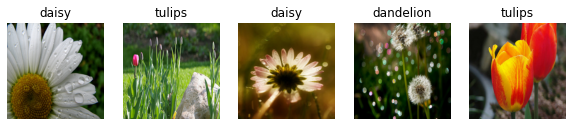

In [ ]:
# preview
plt.figure(figsize=(10,10))
for i, (img, label) in enumerate(zip(img_batch[:5], label_batch[:5])):
    plt.subplot(1,5,i+1)
    plt.imshow(tf.cast(img, dtype=tf.uint8))
    plt.title(class_names[label.numpy()])
    plt.axis('off')

## TF HUB MODEL

`https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2`

The input images are expected to have color values in the range [0,1].

For this model, the size of the input images is fixed to height x width = `512 x 512` pixels.



**Usage**

This model can be used with `hub.KerasLayer` as follows. 

`
m = tf.keras.Sequential([
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2",
                   trainable=False),  # Can be True, finetuning.
    tf.keras.layers.Dense(num_classes, activation='softmax')
])
m.build([None, 512, 512, 3])  # Batch input shape.
`

### Simple model

In [ ]:

model_1 = tf.keras.Sequential([
    tf.keras.layers.Rescaling(scale=1.0/255),
    hub.KerasLayer("https://tfhub.dev/google/imagenet/efficientnet_v2_imagenet21k_xl/feature_vector/2", trainable=False),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Dense(len(class_names))
])

model_1.build([None, 512, 512, 3])  # Batch input shape.


In [ ]:
# model_1.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=0.005, momentum=0.9),
#                 loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#                 metrics=['acc'])


model_1.compile(optimizer='adam', loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True), metrics=['acc'])

In [ ]:
history_1 = model_1.fit(train, epochs=5, validation_data=val)

Epoch 1/5
92/92 [==============================] - 362s 4s/step - loss: 0.4243 - acc: 0.8566 - val_loss: 0.1423 - val_acc: 0.9591
Epoch 2/5
92/92 [==============================] - 328s 4s/step - loss: 0.1046 - acc: 0.9649 - val_loss: 0.1133 - val_acc: 0.9646
Epoch 3/5
92/92 [==============================] - 328s 4s/step - loss: 0.0732 - acc: 0.9748 - val_loss: 0.1221 - val_acc: 0.9619
Epoch 4/5
92/92 [==============================] - 328s 4s/step - loss: 0.0535 - acc: 0.9823 - val_loss: 0.0811 - val_acc: 0.9646
Epoch 5/5
92/92 [==============================] - 327s 4s/step - loss: 0.0415 - acc: 0.9884 - val_loss: 0.1027 - val_acc: 0.9687
